In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import random
import seaborn as sns
import itertools as it

from metric_voting.spatial_generation import Spatial, GroupSpatial, ProbabilisticGroupSpatial

%load_ext autoreload
%autoreload 2

In [2]:
colors = ["#0099cd","#ffca5d","#00cd99","#99cd00","#cd0099","#9900cd","#8dd3c7",
        "#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5","#bc80bd",
        "#ccebc5","#ffed6f","#ffffb3","#a6cee3","#1f78b4","#b2df8a","#33a02c",
        "#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#b15928",
        "#64ffda","#00B8D4","#A1887F","#76FF03","#DCE775","#B388FF","#FF80AB",
        "#D81B60","#26A69A","#FFEA00","#6200EA",
    ]

#### This notebook is intended to be a tutorial for generating voter and candidate positions in metric space, and creating ranked preference profiles from them. 
This is done with the *Spatial*, *GroupSpatial*, and *ProbabilisticGroupSpatial* classes. Each has slightly different usage, but all commonly rely on input metric-space probability distributions for random generation.

# Generation with `Spatial`

The Spatial class takes a single voter distribution function and a single candidate distribution function and generates metric space positions from them. This amounts to creating a single voter bloc (group) and a single candidates group distributed identically around them. In the following example, we create a single gaussian voter bloc with candidates distributed uniformly around them. 

In [3]:
# Voter distribution function and its parameters.
voter_dist_fn = np.random.normal
voter_dist_fn_params = {'loc' : [0,0], 'scale' : 1/6, 'size' : 2}
    
# Candidate distribution function and its parameters.
candidate_dist_fn = np.random.uniform
candidate_dist_fn_params = {'low': -1, 'high': 1, 'size': 2}

# Define a distance function between voters and candidates.
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the spatial generator object.
generator = Spatial(
    voter_dist_fn = voter_dist_fn,
    voter_dist_fn_params = voter_dist_fn_params,
    candidate_dist_fn = candidate_dist_fn,
    candidate_dist_fn_params = candidate_dist_fn_params,
    distance_fn = distance
)

In [4]:
# Now .generate() will make a profile with random candidate and voter positions.
# Inputs n and m specify the number of voters and candidates respectively to draw from the distributions.
# NOTE: For this class, the candidate and voter labels will all be the same, since there is only 
#       a single voter bloc and single candidate group. 
(profile,
candidate_positions,
voter_positions,
candidate_labels,
voter_labels) = generator.generate(n = 1000, m = 200)

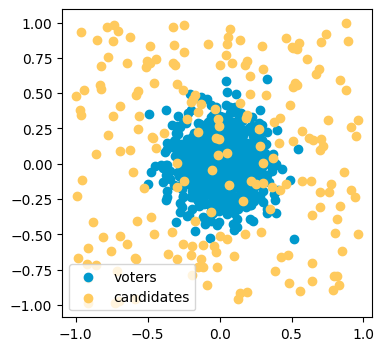

In [5]:
# Visualize the results
plt.figure(figsize = (4,4))
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
#plt.gca().set_aspect('equal')
plt.legend()

In [6]:
# Included in the output is a ranked preference profile, computed by finding distances 
# from each voter to each candidate. 
pd.DataFrame(profile)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,174,106,118,107,90,118,118,138,171,61,...,118,81,168,47,70,106,11,169,134,146
1,169,118,106,168,148,139,138,127,118,155,...,139,161,165,102,74,118,72,174,113,127
2,161,127,171,161,17,160,106,146,139,190,...,160,92,161,146,127,138,46,161,92,172
3,81,174,138,68,84,169,171,172,160,94,...,169,174,81,39,146,127,177,81,41,138
4,106,138,139,81,103,106,139,106,103,93,...,106,169,107,127,88,174,69,17,98,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,147,145,3,32,6,27,27,57,110,35,...,27,104,32,197,175,175,110,76,28,31
196,199,175,27,76,32,6,3,31,6,12,...,6,43,76,57,147,145,27,12,37,57
197,109,3,145,12,12,5,145,175,27,76,...,5,147,12,175,199,3,6,109,104,175
198,43,31,43,109,31,145,31,3,145,109,...,145,199,109,3,3,31,145,31,147,3


Our preference profile takes the shape of an $m \times n$ array. Voters are represented as integers `[0,...,n-1]`, and each column $j$ of the profile represents voter $j$'s ranked ballot. Candidates are similarly represented with integers `[0,...,m-1]` and each row $i$ in the profile shows the candidates which have been given rank $i$ from each of the voters. For example, if `profile[i,j] = c` then this tells us that voter $j$  ranks the candidate $c$ as being their `i`th favorite candidate.  

Importantly, these representations also correspond to indices in the `voter_positions` and `candidate_positions` array. For example, the row `voter_positions[j,:]` gives the $d$-dimensional location of voter $j$ in metric space. Likewise `candidate_positions[c,:]` gives the location for candidate $c$. The same also applies to `voter_labels` and `candidate_labels`, which are similarly indexed to give the group labels of the respective voters and candidates.  

# Generation with `GroupSpatial`

For a setting with multiple blocs (groups) of voters, we may wish to use multiple voter distributions. Likewise, candidates may be split into distinct groups needing their own distributions. In this case, we use the `GroupSpatial` class. For example, consider the following election setting, where voters are drawn from two gaussian distributions and candidates are drawn from two separate uniform distributions.

In [7]:
# Parameters for the gaussian voter distributions:
voter_params = [
    {'loc': [0, -2], 'scale': 1/3, 'size': 2},
    {'loc': [0, 2], 'scale': 1/3, 'size': 2}
]
    
# Parameters for the uniform candidate distributions. 
candidate_params = [{'low': [-1,-3], 'high': [1,-1], 'size': 2}, {'low': [-1,1], 'high': [1,3], 'size': 2}]

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
generator = GroupSpatial(
    n_voter_groups = 2,
    n_candidate_groups = 2, 
    voter_dist_fns = [np.random.normal, np.random.normal],
    voter_dist_fn_params = voter_params,
    candidate_dist_fns = [np.random.uniform, np.random.uniform],
    candidate_dist_fn_params = candidate_params,
    distance_fn = distance
)

In [8]:
# Now .generate() will make a profile with random candidate and voter positions.
(profile,
candidate_positions,
voter_positions,
candidate_labels,
voter_labels) = generator.generate(voter_group_sizes = [500,500], candidate_group_sizes = [100,100])

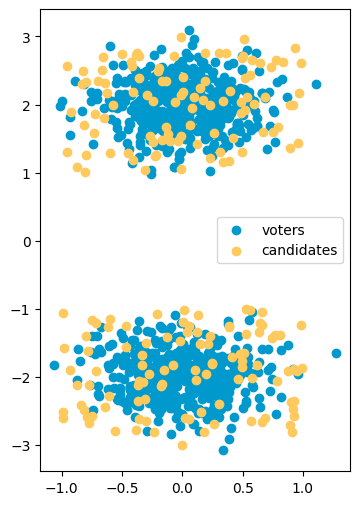

In [9]:
# Visualize the results
plt.figure(figsize = (4,6))
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()

# Generation with `ProbabilisticGroupSpatial`

In a case where the number of voters $n$ and candidates $m$ is known, but exact group sizes are not, we use `ProbabilisticGroupSpatial` as an alternative to `GroupSpatial` which instead takes as input the likelihood of belonging to each group. We can use a similar example to the one before.

In [10]:
# Parameters for the gaussian voter distributions:
voter_params = [
    {'loc': [0, -2], 'scale': 1/3, 'size': 2},
    {'loc': [0, 2], 'scale': 1/3, 'size': 2}
]
    
# Parameters for the uniform candidate distributions. 
candidate_params = [{'low': [-1,-3], 'high': [1,-1], 'size': 2}, {'low': [-1,1], 'high': [1,3], 'size': 2}]

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
generator = ProbabilisticGroupSpatial(
    n_voter_groups = 2,
    n_candidate_groups = 2, 
    voter_dist_fns = [np.random.normal, np.random.normal],
    voter_dist_fn_params = voter_params,
    candidate_dist_fns = [np.random.uniform, np.random.uniform],
    candidate_dist_fn_params = candidate_params,
    distance_fn = distance
)

In [11]:
# Now .generate() will make a profile with random candidate and voter positions.
# Here we give probabilites for group membership instead of exact sizes.
(profile,
candidate_positions,
voter_positions,
candidate_labels,
voter_labels) = generator.generate(n = 1000, m = 200, voter_group_probs = [1/3,2/3], candidate_group_probs = [2/3,1/3])

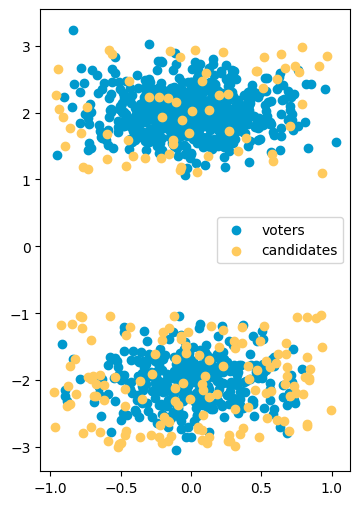

In [12]:
# Visualize the results
plt.figure(figsize = (4,6))
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()